In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

import tensorflow as tf
from setup_mnist import MNIST
from setup_cifar import CIFAR
import os

def train(data, file_name, params, num_epochs=30, batch_size=50, train_temp=1, init=None):
    """
    Standard neural network training procedure.
    """
    model = Sequential()

    print(data.train_data.shape)
    
    model.add(Conv2D(params[0], (5, 5), padding='same',
                            input_shape=data.train_data.shape[1:]))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    model.add(Conv2D(params[1], (5, 5), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    model.add(Conv2D(params[2], (4, 4), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    
    model.add(Flatten())
    model.add(Dense(10))
    
    model.summary()

    
    
#     model.add(Conv2D(params[2], (3, 3)))
#     model.add(Activation('relu'))
#     model.add(Conv2D(params[3], (3, 3)))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Flatten())
#     model.add(Dense(params[4]))
#     model.add(Activation('relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(params[5]))
#     model.add(Activation('relu'))
#     model.add(Dense(10))
    
    if init != None:
        model.load_weights(init)

    def fn(correct, predicted):
        return tf.nn.softmax_cross_entropy_with_logits(labels=correct,
                                                       logits=predicted/train_temp)

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    model.compile(loss=fn,
                  optimizer=sgd,
                  metrics=['accuracy'])
    
    model.fit(data.train_data, data.train_labels,
              batch_size=batch_size,
              validation_data=(data.validation_data, data.validation_labels),
              epochs=num_epochs,
              shuffle=True)
    

    if file_name != None:
        model.save(file_name)

    return model

def train_distillation(data, file_name, params, num_epochs=50, batch_size=128, train_temp=1):
    """
    Train a network using defensive distillation.
    Distillation as a Defense to Adversarial Perturbations against Deep Neural Networks
    Nicolas Papernot, Patrick McDaniel, Xi Wu, Somesh Jha, Ananthram Swami
    IEEE S&P, 2016.
    """
    if not os.path.exists(file_name+"_init"):
        # Train for one epoch to get a good starting point.
        train(data, file_name+"_init", params, 1, batch_size)
    
    # now train the teacher at the given temperature
    teacher = train(data, file_name+"_teacher", params, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # evaluate the labels at temperature t
    predicted = teacher.predict(data.train_data)
    with tf.Session() as sess:
        y = sess.run(tf.nn.softmax(predicted/train_temp))
        print(y)
        data.train_labels = y

    # train the student model at temperature t
    student = train(data, file_name, params, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # and finally we predict at temperature 1
    predicted = student.predict(data.train_data)

    print(predicted)

/home/tianwei/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# # dont need to train again
# if not os.path.isdir('models'):
#     os.makedirs('models')

# hidden_param = [10, 25, 100]
# train(MNIST(), "models/mnist", hidden_param, num_epochs=30)

# train_distillation(MNIST(), "models/mnist-distilled-100", hidden_param,
#                    num_epochs=30, train_temp=100)

In [3]:
import tensorflow as tf
import numpy as np
import time

from setup_cifar import CIFAR, CIFARModel
from setup_mnist import MNIST, MNISTModel
from setup_inception import ImageNet, InceptionModel

from l2_attack import CarliniL2
from l0_attack import CarliniL0
from li_attack import CarliniLi


# def show(img):
#     """
#     Show MNSIT digits in the console.
#     """
#     remap = "  .*#"+"#"*100
#     img = (img.flatten()+.5)*3
#     if len(img) != 784: return
#     print("START")
#     for i in range(28):
#         print("".join([remap[int(round(x))] for x in img[i*28:i*28+28]]))


def generate_data(data, samples, targeted=True, start=0, inception=False):
    """
    Generate the input data to the attack algorithm.
    data: the images to attack
    samples: number of samples to use
    targeted: if true, construct targeted attacks, otherwise untargeted attacks
    start: offset into data to use
    inception: if targeted and inception, randomly sample 100 targets intead of 1000
    """
    inputs = []
    targets = []
    for i in range(samples):
        if targeted:
            if inception:
                seq = random.sample(range(1,1001), 10)
            else:
                seq = range(data.test_labels.shape[1])

            for j in seq:
                if (j == np.argmax(data.test_labels[start+i])) and (inception == False):
                    continue
                inputs.append(data.test_data[start+i])
                targets.append(np.eye(data.test_labels.shape[1])[j])
        else:
            inputs.append(data.test_data[start+i])
            targets.append(data.test_labels[start+i])

    inputs = np.array(inputs)
    targets = np.array(targets)

    return inputs, targets

In [4]:
# sess = tf.Session()
# tf.global_variables_initializer().run()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
# sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

data, model =  MNIST(), MNISTModel("models/mnist", sess)
# attack = CarliniL0(sess, model,  max_iterations=1000)
attack = CarliniL2(sess, model, batch_size=9, max_iterations=1000, confidence=0)

inputs, targets = generate_data(data, samples=1, targeted=True,
                                start=0, inception=False)

In [5]:
print(inputs.shape )
print(targets )

(9, 28, 28, 1)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [6]:
timestart = time.time()
adv = attack.attack(inputs, targets)
timeend = time.time()

print("Took",timeend-timestart,"seconds to run",len(inputs),"samples.")

go up to 9
tick 0
[10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
0 (0.36034116, 0.35169062, 0.008650551)
100 (0.3535604, 0.3530026, 0.0005577672)
200 (0.3535602, 0.35300255, 0.0005576729)
[10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
0 (3.5255797, 3.5168762, 0.008703454)
100 (3.4890883, 3.4385529, 0.050535373)
200 (3.4886823, 3.4383464, 0.050336003)
300 (3.4739664, 3.411605, 0.062361367)
400 (3.4593298, 3.37885, 0.080479965)
500 (3.4554136, 3.3700428, 0.085370794)
600 (3.4539719, 3.3667529, 0.08721889)
700 (3.4533885, 3.365415, 0.08797343)
800 (3.4531674, 3.3647454, 0.088421986)
[10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
0 (35.17744, 35.16873, 0.008709197)
100 (31.02943, 27.656881, 3.3725495)
200 (30.537556, 26.150162,

In [9]:
%matplotlib inline
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


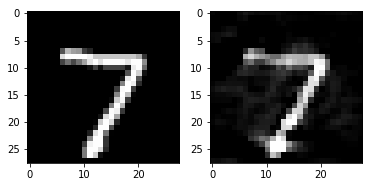

Score: [  7.4459376  -7.860144    3.4704938   5.632467   -4.483472   -6.6543665
 -14.5994      7.4388957   1.6399295   0.3053197]
output:  0
Total distortion: 2.4333231424963078


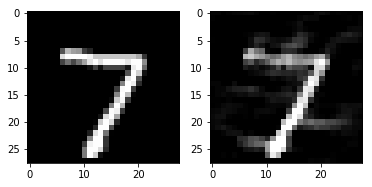

Score: [ -5.890569    7.1898203   4.897822    7.1068473   0.7684277  -2.6003454
 -21.378855    7.1670456  -3.3384738   1.4255835]
output:  1
Total distortion: 2.6475167713588643


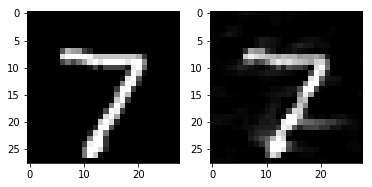

Score: [ -2.747247   -5.7765484  13.321507    8.784753   -2.1887383 -10.304651
 -20.878311   13.31489     1.4158758  -3.562688 ]
output:  2
Total distortion: 1.9308152088976938


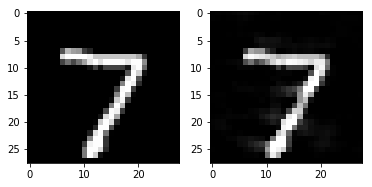

Score: [ -9.88249    -8.876221   -2.0867777  19.809242   -5.217216   -1.4525872
 -26.53228    19.807537   -3.0771396   5.813724 ]
output:  3
Total distortion: 1.2235190665190139


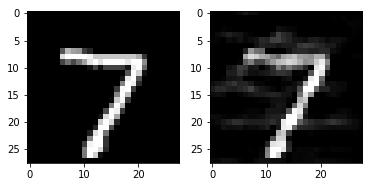

Score: [ -5.01784    -7.4696994   1.1797607   8.556499    8.740145   -7.124036
 -18.321245    8.736441   -1.166626    3.9772165]
output:  4
Total distortion: 2.336913348340102


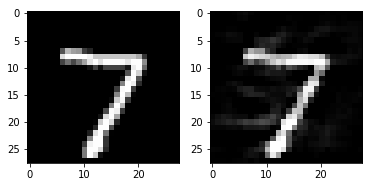

Score: [-12.584514  -10.174899   -6.278785   13.376694   -5.8536572  13.448348
 -21.923994   13.445035   -1.0712177   7.933717 ]
output:  5
Total distortion: 1.8673782570413004


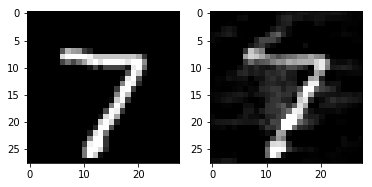

Score: [  2.6532464 -11.378548   -1.0774891   3.4465134  -2.5935388  -2.9203074
   3.4740665   3.4640381   1.6534986  -2.866327 ]
output:  6
Total distortion: 2.9159036092328914


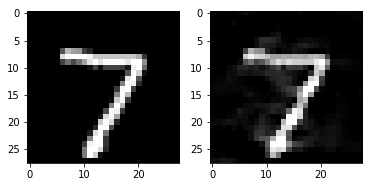

Score: [ -5.565991   -9.879321    1.3213627   9.734439   -4.425713   -2.580251
 -17.110651    9.763069    9.76447     0.827357 ]
output:  8
Total distortion: 1.9919973843683743


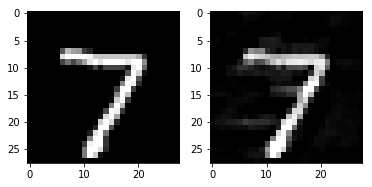

Score: [-10.841464   -8.9396305  -7.290247   13.16295    -2.8858802   1.088746
 -24.274292   15.160672   -1.9353048  15.171094 ]
output:  9
Total distortion: 1.5424446084882648


In [10]:


for org_img, adv_img in zip(inputs, adv):
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(np.reshape(org_img, (28,28)), cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(np.reshape(adv_img, (28,28)), cmap="gray")
#     plt.colorbar()
    plt.show()
    pred_score = model.model.predict(adv_img.reshape( (1,adv_img.shape[0],adv_img.shape[1],adv_img.shape[2] )))
    print("Score:",pred_score[0])
    print('output: ', np.argmax(pred_score[0]) )
    print("Total distortion:", np.sum((adv_img-org_img)**2)**.5)
    
#     break

In [13]:
file_name = 'L2_attack'
np.savez(file_name, inputs, adv)